In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os.path
sys.path.append(
    os.path.abspath(os.path.dirname(os.path.abspath(''))))

from simulation import Parameters
from equations import solveDiscrete, decayLengthPhysical, get_kd, get_v
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import os
import plotly.express as px

# Density on single mt:
dat = []
mt_length = 500
x = np.arange(0,mt_length*0.008,0.008)
t = np.linspace(0,100,100)

beta = np.arange(0.8,0,-0.1)

p = Parameters()
counter = 1
for filename in os.listdir('./config/'):
    for gamma in [1, 0.5]:
        # p.read('./config/' + os.listdir('./config/')[5])
        p.read('./config/' + filename)
        p.beta = beta
        p.P_lose = 0.1
        p.omega = 0.1
        p.gamma = gamma
        p.delta = gamma
        solution = solveDiscrete(p,t,mt_length)
        velocities = np.apply_along_axis(get_v, 1, solution, p)
        v = velocities[:,0]
        accumulation = np.sum(solution-p.alpha,axis=1)
        y = solution[-1]-p.alpha
        y = y/y[0]
        d = decayLengthPhysical(p, v[-1])
        ye = np.exp(-x/d)
        a = 1 - accumulation/accumulation[-1]
        t_const = t[np.where(a < 0.367879441)[0][0]]
        print(counter, 'diff:', p.D, ' off from steady state:', (accumulation[-1]-accumulation[-2])/accumulation[-1], 
              'error in decay length:', np.max(y-ye))
        dat.append({'alpha':p.alpha, 'beta':p.beta, 'omega':p.omega, 'D':p.D, 'koff':p.koff, 'decay_length':d, 't_const':t_const, 'gamma': p.gamma, 'delta':p.delta,
                    'v':v, 'v_shift':velocities[:,1], 'v_lose':velocities[:,2], 'p':p, 'accumulation':accumulation, 'solution':solution})
        counter += 1

colorcoded = 'gamma'

1 diff: 0.093  off from steady state: 4.6479194555633675e-06 error in decay length: 0.0054928993141581395
2 diff: 0.093  off from steady state: 0.00016864812584739742 error in decay length: 0.004821521778274107
3 diff: 0.093  off from steady state: 6.7190632305605075e-06 error in decay length: 0.013010994298898293
4 diff: 0.093  off from steady state: 0.0002308207558150792 error in decay length: 0.00795987529943809
5 diff: 0.093  off from steady state: 1.0359610405109486e-05 error in decay length: 0.0219734301812492
6 diff: 0.093  off from steady state: 0.00023346391579474415 error in decay length: 0.011178602249004466
7 diff: 0.093  off from steady state: 2.328148790746079e-05 error in decay length: 0.021846278727055246
8 diff: 0.093  off from steady state: 0.00011743223364366908 error in decay length: 0.011780502374663993
9 diff: 0.093  off from steady state: 1.8653981486008663e-05 error in decay length: 0.019599129007779492
10 diff: 0.093  off from steady state: 5.9522764559363e-05 

In [2]:
# # abc = list(filter(lambda dic: dic["beta"].beta == 1, dat))
# # plotdat = list(filter(lambda dic: dic["beta"] == 1, dat))
# # from equations import solveDiscrete, decayLengthPhysical, get_kd, get_v
# # vs = np.apply_along_axis(get_v, 1, solution, p)
# # vs[:,1]
# import pandas as pd
# # df = pd.DataFrame.from_dict(my_dict)
# df = pd.DataFrame(dat)
# fig = px.line(df, x='v', y='v_shift', color='D', markers=True)
# fig.show()

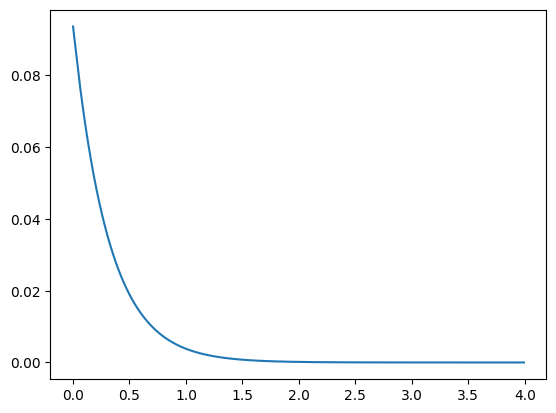

In [3]:
y = dat[0]["solution"][-1]-dat[0]["alpha"]
# y = y/y[0]

plt.plot(x,y)
# d = decayLengthPhysical(dat[0]["p"], dat[0]["speed"][-1])
# ye = np.exp(-x/d)
# np.max(y-ye)
# plt.plot(x,ye)


In [4]:
# from equations import solveDiscrete, decayLengthPhysical, get_v
# P = dat[0]["solution"][-1]
# # P[:] = p.alpha

# k0 = p.depol_rate
# p.beta = np.arange(0.8,0,-0.2)
# p.omega = 0.1
# # P = np.array([1,1,0,0,0,0,0,1])

# kd, P_shift, P_lose = get_v(P, p)

# len(dat[0]["solution"])
# fig, ax = plt.subplots()
# # np.array([kd, k0, k0 * (1.-P[0]), k0 * P[0] * (P_shift[0] + P_lose)]) * p.a

Text(0, 0.5, 'Depolymerization speed\n (μm/s)')

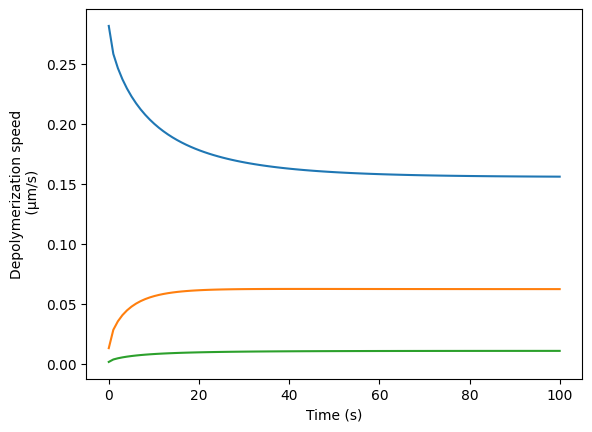

In [5]:
n = 5
v = dat[n]["v"]; v_shift = dat[n]["v_shift"]; v_lose = dat[n]["v_lose"]
plt.plot(t,v,t,v_shift,t,v_lose)
plt.xlabel("Time (s)")
plt.ylabel("Depolymerization speed\n (\u03bcm/s)")


In [6]:
import matplotlib
import matplotlib.cm as cm

font = {'size'   : 18}

matplotlib.rc('font', **font)
   
norm = matplotlib.colors.Normalize(vmin=0, vmax=1.22)
cmap = cm.gist_ncar
colors = cm.ScalarMappable(norm=norm, cmap=cmap)

def setMarker(val, permitted_values):
    if val == permitted_values[0]:
        return '^'
    elif val == permitted_values[1]:
        return 'o'
    elif val == permitted_values[2]:
        return 'x'
    elif val == permitted_values[3]:
        return '>'
    
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

def df(plotdic, key):
    if isinstance(plotdic[0][key], float) or isinstance(plotdic[0][key], int):
        return np.array([dic[key] for dic in plotdic])
    else:
        return np.array([dic[key][-1] for dic in plotdic])
    
def standard_plot(plotdat, xkey, ykey):
    plt.figure(figsize=(5,5))
    unique_vals = list(set([dic['D'] + dic['koff'] for dic in plotdat]))
    print(df(plotdat,xkey))
    color = df(plotdat,colorcoded)
    mscatter(df(plotdat,xkey),
         df(plotdat,ykey), 
         c=color,
         m=[setMarker(dic['D'] + dic['koff'], unique_vals) for dic in plotdat],
         s=200, facecolors='none', alpha=0.6, norm=norm, cmap=cmap, label=color)

# colors = list(set(df(plotdat,'omega')))

def saveallfigs(name):
    plt.savefig(name + ".svg", transparent=True)
    plt.savefig(name + ".png", transparent=True, bbox_inches='tight')

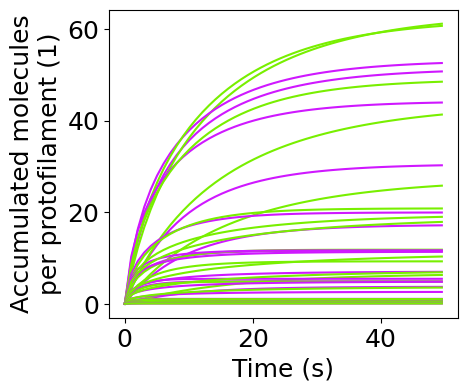

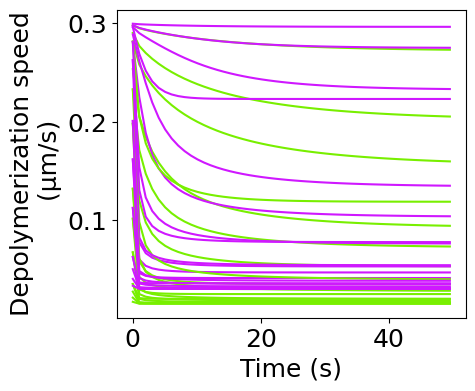

In [7]:
# filtered = list(filter(lambda condition: condition['D'] == 0.0093, plotdat))
filtered = dat#list(filter(lambda condition: 0.1 > condition['alpha'] > 0.05 and condition['D'] == 0.093, plotdat))

plt.figure(figsize=(4.5,4))
tmax = np.where(t >= 50)[0][0]
for curve in filtered:
    accumulation = curve["accumulation"]
    plt.plot(t[0:tmax],accumulation[0:tmax], label=str(curve[colorcoded]), color = colors.to_rgba(curve[colorcoded]))
    
plt.xlabel("Time (s)")
plt.ylabel("Accumulated molecules\nper protofilament (1)")
saveallfigs("figs/time vs accumulation")

plt.figure(figsize=(4.5,4))
for curve in filtered:
    v = curve["v"]
    plt.plot(t[0:tmax],v[0:tmax], label=str(curve[colorcoded]), color = colors.to_rgba(curve[colorcoded]))
plt.xlabel("Time (s)")
plt.ylabel("Depolymerization speed\n (\u03bcm/s)")
saveallfigs("figs/time vs speed")

[0.01234568 0.01234568 0.05882353 0.05882353 0.11111111 0.11111111
 0.27272727 0.27272727 0.38461538 0.38461538 0.55555556 0.55555556
 0.78947368 0.78947368 0.86206897 0.86206897 0.92592593 0.92592593
 0.97402597 0.97402597 0.11111111 0.11111111 0.38461538 0.38461538
 0.55555556 0.55555556 0.78947368 0.78947368 0.86206897 0.86206897
 0.92592593 0.92592593 0.97402597 0.97402597 0.98425197 0.98425197
 0.99206349 0.99206349 0.99734043 0.99734043]


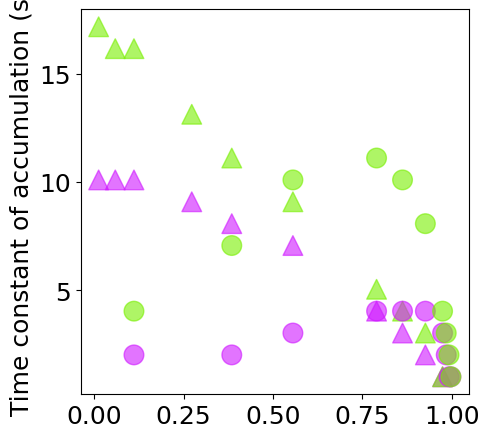

In [8]:
plotdat = dat
standard_plot(plotdat, 'alpha', 't_const')
plt.ylabel('Time constant of accumulation (s)')
# plt.xlabel("Ase1 density (1/protofilament dimer)")
# plt.ylim([0,25])
saveallfigs("figs/ase1 density vs time constant of accumulation ")

[0.01234568 0.01234568 0.05882353 0.05882353 0.11111111 0.11111111
 0.27272727 0.27272727 0.38461538 0.38461538 0.55555556 0.55555556
 0.78947368 0.78947368 0.86206897 0.86206897 0.92592593 0.92592593
 0.97402597 0.97402597 0.11111111 0.11111111 0.38461538 0.38461538
 0.55555556 0.55555556 0.78947368 0.78947368 0.86206897 0.86206897
 0.92592593 0.92592593 0.97402597 0.97402597 0.98425197 0.98425197
 0.99206349 0.99206349 0.99734043 0.99734043]


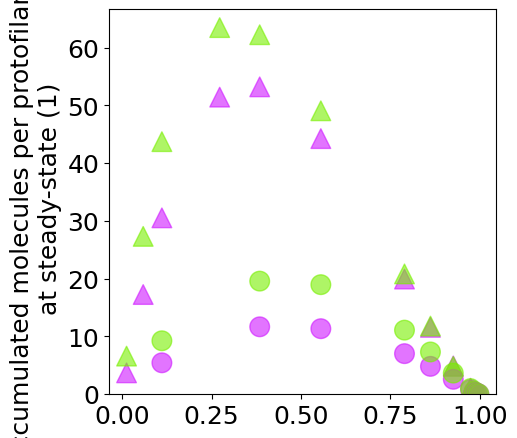

In [9]:
standard_plot(plotdat, 'alpha', 'accumulation')
plt.ylabel("Accumulated molecules per protofilament\n at steady-state (1)")
# plt.xlabel("Ase1 density (1/protofilament dimer)")
plt.ylim(0)
saveallfigs("figs/ase1 density vs accumulated molecules")


[0.01234568 0.01234568 0.05882353 0.05882353 0.11111111 0.11111111
 0.27272727 0.27272727 0.38461538 0.38461538 0.55555556 0.55555556
 0.78947368 0.78947368 0.86206897 0.86206897 0.92592593 0.92592593
 0.97402597 0.97402597 0.11111111 0.11111111 0.38461538 0.38461538
 0.55555556 0.55555556 0.78947368 0.78947368 0.86206897 0.86206897
 0.92592593 0.92592593 0.97402597 0.97402597 0.98425197 0.98425197
 0.99206349 0.99206349 0.99734043 0.99734043]


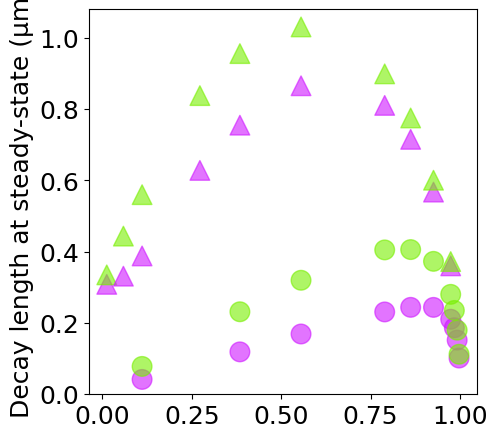

In [10]:
standard_plot(plotdat, 'alpha', 'decay_length')

plt.ylabel("Decay length at steady-state (\u03bcm)")
# plt.xlabel("Ase1 density (1/protofilament dimer)")
plt.ylim(0)
saveallfigs("figs/ase1 density vs decay length")


[0.01234568 0.01234568 0.05882353 0.05882353 0.11111111 0.11111111
 0.27272727 0.27272727 0.38461538 0.38461538 0.55555556 0.55555556
 0.78947368 0.78947368 0.86206897 0.86206897 0.92592593 0.92592593
 0.97402597 0.97402597 0.11111111 0.11111111 0.38461538 0.38461538
 0.55555556 0.55555556 0.78947368 0.78947368 0.86206897 0.86206897
 0.92592593 0.92592593 0.97402597 0.97402597 0.98425197 0.98425197
 0.99206349 0.99206349 0.99734043 0.99734043]


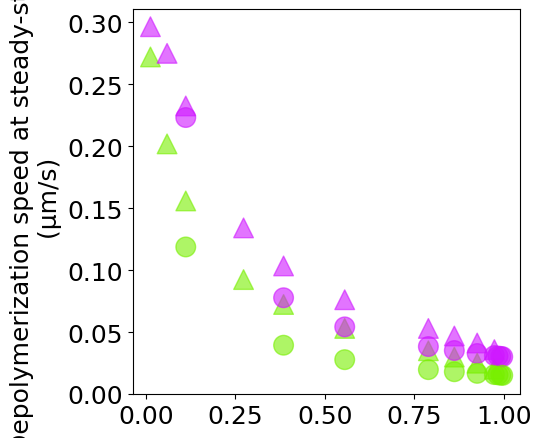

In [11]:
standard_plot(plotdat, 'alpha', 'v')

plt.ylabel("Depolymerization speed at steady-state\n (\u03bcm/s)")
plt.ylim(0)
saveallfigs("figs/ase1 density vs depolymerization speed")

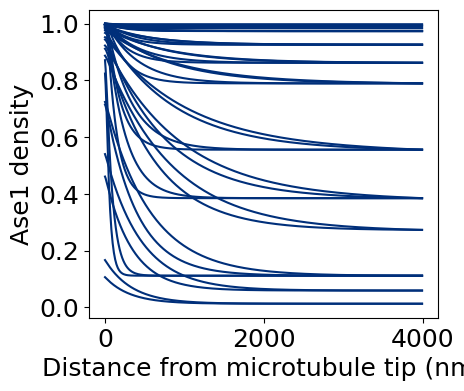

In [12]:
filtered = list(filter(lambda condition: 0.1 > condition['alpha'] > 0.05 and condition['D'] == 0.093, plotdat))
plt.figure(figsize=(4.5,4))
for curve in dat:
    solution = curve["solution"]
    y = solution[-1][:]
    plt.plot(x*1000,y, color = colors.to_rgba(curve['beta'][-1]))

plt.xlabel("Distance from microtubule tip (nm)")
plt.ylabel("Ase1 density")
saveallfigs("figs/distance versus Ase1 density")

# d = decayLengthPhysical(dat[index]["p"], dat[index]["speed"][-1])
# ye = np.exp(-x/d)
# np.max(y-ye)
# plt.plot(x,ye)